In [ ]:
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

## Load Dataset

In [14]:
df = pd.read_csv("data.csv")
df.columns = ["message", "category"]
df.head()

,message,category
0,Final notice. Update your info: https://verify...,Spam
1,Reset your password now at https://get-rich-fa...,Spam
2,Your transaction ID is TXN471861. Please keep ...,Transactional
3,Your package with tracking ID 162556 has been ...,Transactional
4,Earn money fast! Start today: https://login-no...,Spam


## Cleaning of Data

In [16]:
def clean_message(msg):
    if not isinstance(msg, str):
        return ""
    msg = msg.lower()
    msg = re.sub(r"[^a-zA-Z\s]", " ", msg)
    msg = re.sub(r"\s+", " ", msg).strip()
    return msg

# Remove duplicates & clean
df.drop_duplicates(subset="message", inplace=True)
df["cleaned_message"] = df["message"].apply(clean_message)
df = df[df["cleaned_message"] != ""]

# Map categories
category_mapping = {"transactional": 0, "promotional": 1, "spam": 2}
df["category_numeric"] = df["category"].str.lower().map(category_mapping)
df.dropna(subset=["category_numeric"], inplace=True)
df["category_numeric"] = df["category_numeric"].astype(int)
df.head()

,message,category,cleaned_message,category_numeric
0,Final notice. Update your info: https://verify...,Spam,final notice update your info https verify now...,2
1,Reset your password now at https://get-rich-fa...,Spam,reset your password now at https get rich fast...,2
2,Your transaction ID is TXN471861. Please keep ...,Transactional,your transaction id is txn please keep it for ...,0
3,Your package with tracking ID 162556 has been ...,Transactional,your package with tracking id has been shipped,0
4,Earn money fast! Start today: https://login-no...,Spam,earn money fast start today https login now se...,2


## Save cleaned dataset

In [25]:
df[["message", "category", "cleaned_message"]].to_csv("labeled_dataset.csv", index=False)
ld = pd.read_csv('labeled_dataset.csv')
ld.head()

,message,category,cleaned_message
0,Final notice. Update your info: https://verify...,Spam,final notice update your info https verify now...
1,Reset your password now at https://get-rich-fa...,Spam,reset your password now at https get rich fast...
2,Your transaction ID is TXN471861. Please keep ...,Transactional,your transaction id is txn please keep it for ...
3,Your package with tracking ID 162556 has been ...,Transactional,your package with tracking id has been shipped
4,Earn money fast! Start today: https://login-no...,Spam,earn money fast start today https login now se...


## Check for train/test leakage 

In [ ]:
X = df["cleaned_message"]
y = df["category_numeric"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

overlap = set(X_train) & set(X_test)


## Feature Extraction

In [19]:
tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Models with class_weight / regularization


🚀 Training: Naive Bayes
5-Fold CV Accuracy: 0.9876
Test Accuracy: 0.9893
Classification Report:
                precision    recall  f1-score   support

transactional       1.00      0.99      0.99       804
  promotional       0.69      1.00      0.82        20
         spam       1.00      1.00      1.00        20

     accuracy                           0.99       844
    macro avg       0.90      1.00      0.94       844
 weighted avg       0.99      0.99      0.99       844



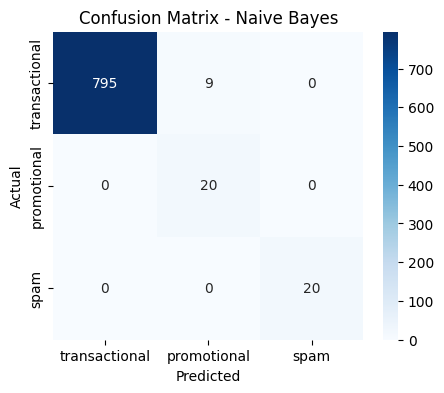

ROC-AUC Score: 0.9963139400086943
✅ Naive Bayes model saved -> naive_bayes_model.pkl

🚀 Training: Logistic Regression
5-Fold CV Accuracy: 0.9896
Test Accuracy: 0.9905
Classification Report:
                precision    recall  f1-score   support

transactional       1.00      0.99      0.99       804
  promotional       0.71      1.00      0.83        20
         spam       1.00      1.00      1.00        20

     accuracy                           0.99       844
    macro avg       0.90      1.00      0.94       844
 weighted avg       0.99      0.99      0.99       844



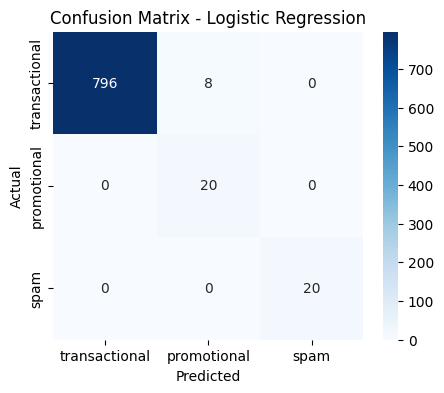

ROC-AUC Score: 0.9967235022299507
✅ Logistic Regression model saved -> logistic_regression_model.pkl

🚀 Training: Linear SVM
5-Fold CV Accuracy: 0.9997
Test Accuracy: 1.0000
Classification Report:
                precision    recall  f1-score   support

transactional       1.00      1.00      1.00       804
  promotional       1.00      1.00      1.00        20
         spam       1.00      1.00      1.00        20

     accuracy                           1.00       844
    macro avg       1.00      1.00      1.00       844
 weighted avg       1.00      1.00      1.00       844



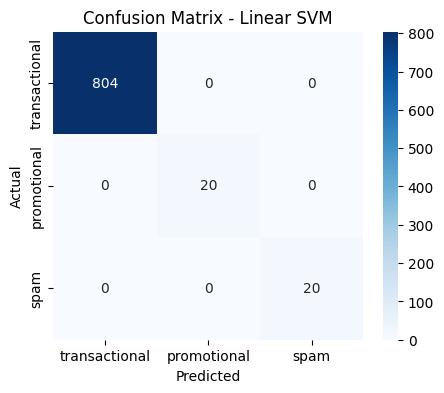

ROC-AUC Score: 1.0
✅ Linear SVM model saved -> linear_svm_model.pkl


In [20]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Linear SVM": LinearSVC(max_iter=5000, class_weight="balanced")
}

best_model = None
best_acc = 0
cv_results = []

for name, model in models.items():
    print(f"\n🚀 Training: {name}")

    # 5-fold Stratified CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_acc = []
    for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
        model.fit(X_train_tfidf[train_idx], y_train.iloc[train_idx])
        val_pred = model.predict(X_train_tfidf[val_idx])
        cv_acc.append(accuracy_score(y_train.iloc[val_idx], val_pred))
    mean_cv_acc = np.mean(cv_acc)
    print(f"5-Fold CV Accuracy: {mean_cv_acc:.4f}")

    # Train on full training set
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=category_mapping.keys()))

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys(), cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC-AUC
    y_test_bin = label_binarize(y_test, classes=[0,1,2])
    y_pred_bin = label_binarize(y_pred, classes=[0,1,2])
    auc = roc_auc_score(y_test_bin, y_pred_bin, average="macro")
    print("ROC-AUC Score:", auc)

    # Save individual model
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.pkl")
    print(f"✅ {name} model saved -> {name.replace(' ', '_').lower()}_model.pkl")

    # Track best model
    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model

    # Store for comparison
    cv_results.append({"Model": name, "CV Accuracy": mean_cv_acc, "Test Accuracy": test_acc, "ROC-AUC": auc})